In [1]:
%load_ext gams.magic
m = gams.exchange_container

# Problem Statement
A farmer has 500 acres of land to allocate to wheat, corn and sugar beats. Their goal is to minimize the total cost of their operations (equivalently, maximize their profit). Note that one of the crucial constraints is that they have to plant enough crops to feet the cattle. The yield depends on weather conditions, and 3 scenarios would be considered: Bad, Good and Average, each with a 1/3 chance of happening. Information about the problem can be seen in the table below: 
| |Wheat|Corn  |Sugar Beets| 
|-----|:-----|:---:|:-----:|
|Bad Yield (T/acre)  |3  |3.6   |24    |
|Average Yield (T/acre)|2.5|3   |20 |
|Good Yield (T/acre)|2|2.4   |16 |
|Need for cattle feed (T)|200|240   | |
|Planting cost (Dollars / acre)|150|230   |260 |
|Selling price (Dollars / T)|170|150 |36|
|Purchase price (Dolalrs / T)|238|210   ||

# Variables Definition
$$x_1 = \# \text{ of acres to allocate to planting wheat}$$
$$x_2 = \# \text{ of acres to allocate to planting corn}$$
$$x_3 = \# \text{ of acres to allocate to planting sugarbeets}$$
$$p_1 = \# \text{ of tons of wheat to sell}$$
$$p_2 = \# \text{ of tons of corn to sell}$$
$$p_3 = \# \text{ of tons of sugarbeets to sell}$$
$$y_1 = \# \text{ of tons of wheat to buy}$$
$$y_2 = \# \text{ of tons of corn to buy}$$

# Two Stage Stochastic Programming Version
$$min \; c^T x + \Sigma_\omega p_\omega d_\omega ^ T y_\omega$$
$$Ax = b$$
$$T_\omega x + W_\omega y_\omega = h_\omega$$
$$x \geq 0, y_\omega \geq 0$$
where $Ax = b$ defines constraints on the first stage variable, and $T_\omega x + W_\omega y_\omega = h_\omega$ defines constraints that link the first and second stage variable.

## Model

In [2]:
%%gams
option limrow = 0, limcol = 0;
****************************** Data ******************************

set scenarios /'good', 'average', 'bad'/;
set crops /'wheat', 'corn', 'sugarbeets'/;


parameter probability(scenarios) 'probability of each scenario materializing'
/
good [1/3],
bad [1/3],
average [1/3]
/;

table yield(crops, scenarios)
                good    average     bad
wheat           3       2.5         2
corn            3.6     3           2.4
sugarbeets      24      20          16
;

parameter cost(crops) 'cost to plant per acre'
/
wheat 150,
corn 230,
sugarbeets 260
/;

positive variable x(crops) '# of acres of land to allocate to wheat, corn, and sugarbeets',
                  p(crops, scenarios) '# of tons of each type of crops to sell in each scenario',
                  y(crops, scenarios) '# of tons of wheat/corn to buy in each scenario'
                  ;
                  
variable obj;

****************************** Model ******************************

equations objective, firstStage, wheatfeeding, cornfeeding, sellingBeets;

objective..
    obj =e= sum(crops, cost(crops) * x(crops)) + sum(scenarios, probability(scenarios) * (238 * y('wheat', scenarios) + 210 * y('corn', scenarios) - 170 * p('wheat', scenarios) - 150 * p('corn', scenarios) - 36 * p('sugarbeets', scenarios) ));
    
firstStage..
    sum(crops, x(crops)) =l= 500;
    
wheatfeeding(scenarios)..
    yield('wheat', scenarios) * x('wheat') + y('wheat', scenarios) - p('wheat', scenarios) =g= 200;

cornfeeding(scenarios)..
    yield('corn', scenarios) * x('corn') + y('corn', scenarios) - p('corn', scenarios) =g= 240;

sellingBeets(scenarios)..
    p('sugarbeets', scenarios) =l= yield('sugarbeets', scenarios) * x('sugarbeets');


model statisticalFarming /all/;
    
solve statisticalFarming using lp min obj;

display x.l, p.l, y.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),-132000.0,11,19,LP,CPLEX,0.007


# CVaR Version
$$min \; c^T x + CVaR_\alpha (Q(x, \omega))$$
$$Ax = b$$
$$x \geq 0$$
where 
$$\text{where }Q(x, \omega) = min \; d_\omega ^ T y_\omega$$
$$T_\omega x + W_\omega y_\omega = h_\omega$$
$$y_\omega \geq 0$$

Equivalently, after reformulating it with (Rockafeller-Uryasev's paper), we have: 
$$min \; c^T x + \gamma + \frac{1}{ 1- \alpha } \Sigma_\omega u_\omega$$
$$Ax = b$$
$$u_\omega \geq d_\omega ^ T y_\omega - \gamma$$
$$T_\omega x + W_\omega y_\omega = h_\omega$$
$$x \geq 0, y_\omega \geq 0, u_\omega \geq 0$$

## GAMS Model
This model assumes a confidence level (alpha) of $\frac{1}{3}$

In [3]:
%%gams
option limrow = 0, limcol = 0;
****************************** Data ******************************

set scenarios /'good', 'average', 'bad'/;
set crops /'wheat', 'corn', 'sugarbeets'/;

parameter alpha 'confidence level for CVaR';
alpha = [1/3];
* When alpha is 2/3, we look at the average of the worst case after that, which is just the 'bad' case. When we only look at this case, 599950 is our optimal solution, so this makes sense

parameter probability(scenarios) 'probability of each scenario materializing'
/
good [1/3],
bad [1/3],
average [1/3]
/;

table yield(crops, scenarios)
                good    average     bad
wheat           3       2.5         2
corn            3.6     3           2.4
sugarbeets      24      20          16
;

parameter cost(crops) 'cost to plant per acre'
/
wheat 150,
corn 230,
sugarbeets 260
/;


positive variable x(crops) '# of acres of land to allocate to wheat, corn, and sugarbeets',
                  p(crops, scenarios) '# of tons of each type of crops to sell in each scenario',
                  y(crops, scenarios) '# of tons of wheat/corn to buy in each scenario',
                  u(scenarios) 'auxiliar variables for reformulation of CVaR'
                  ;
                  
variable obj, gamma;


****************************** Model ******************************


equations objective, firstStage, wheatfeeding, cornfeeding, sellingBeets, CVaR;

objective..
    obj =e= sum(crops, cost(crops) * x(crops)) + gamma + [1/(1-alpha)] * sum(scenarios, probability(scenarios) * u(scenarios));
    
* Ax = b
firstStage..
    sum(crops, x(crops)) =l= 500;
    
*** These are equations binding the first stage variable with second stage variables ***
wheatfeeding(scenarios)..
    yield('wheat', scenarios) * x('wheat') + y('wheat', scenarios) - p('wheat', scenarios) =g= 200;

cornfeeding(scenarios)..
    yield('corn', scenarios) * x('corn') + y('corn', scenarios) - p('corn', scenarios) =g= 240;

sellingBeets(scenarios)..
    p('sugarbeets', scenarios) =l= yield('sugarbeets', scenarios) * x('sugarbeets');

*** u(Omega) >= d(omega)^T y(omega) - gamma ***
CVaR(scenarios)..
    u(scenarios) =g= (238 * y('wheat', scenarios) + 210 * y('corn', scenarios) - 170 * p('wheat', scenarios) - 150 * p('corn', scenarios) - 36 * p('sugarbeets', scenarios)) - gamma

model statisticalFarming /all/;
    
solve statisticalFarming using lp min obj;

display x.l, p.l, y.l, u.l, gamma.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),-96000.0,14,23,LP,CPLEX,0.002


# CVaR Version Using Bender's Decomposition
By treating the first stage variables ($x_1, x_2, x_3, \gamma$) as complication variables, we can solve this problem using Bender's Decomposition with the following master problem and subproblem:

### Subproblem (One for each scenario $\omega$)
$$min \frac{1}{1-\alpha} p_\omega u_\omega$$
$$u_\omega \geq d_\omega ^ T y_\omega - \gamma$$
$$T_\omega x + W_\omega y_\omega = h_\omega$$
$$y_\omega \geq 0$$
$$u_\omega \geq 0$$
$$x = x^{fixed} \; \; \perp \pi_\omega^{(k)}$$
$$\gamma = \gamma ^ {fixed}\; \; \perp \phi_\omega^{(k)}$$
where $k$ denotes the current iteration of the algorithm.


### Master Problem
$$min \; c^Tx^{(i)} + \gamma^{(i)} + \alpha^{(i)}$$
$$Ax^{(i)} = b$$
$$x^{(i)} \geq 0$$
$$\alpha^{(i)} \geq \Sigma_\omega (\frac{1}{1-\alpha} p_\omega u_\omega ^{(k)}) + \Sigma_\omega \phi_\omega ^{(k)} (x^{(i)} - x^{(k)}) + \Sigma_\omega \pi_\omega^{(k)} (\gamma^{(i)} - \gamma^{(k)}) \text{ for }k = 1, ..., i-1$$
$$\alpha^{(i)} \geq \alpha_{down}$$
$$\gamma^{(i)} \geq \gamma_{down}$$
where $i$ denotes the current iteration of the algorithm. 
We need explicit bounds on alpha and gamma so that the master problem does not go unbounded on the first iteration.

## GAMS Model

In [4]:
gams.reset()
m = gams.exchange_container

In [5]:
%%gams
sets
crops /'wheat', 'corn', 'sugarbeets'/
scenarios /lo,mid,hi/
;

table yield(crops,scenarios) ’possible outcomes for demand’
            lo  mid hi
wheat       2   2.5 3
corn        2.4 3   3.6
sugarbeets  16  20  24
;

parameter alpha 'confidence level for CVaR';
alpha = [1/3];


parameter probability(scenarios) ’probability of each scenario materializing’
/
lo [1/3]
mid [1/3]
hi [1/3]
/;

parameter cost(crops) 'cost to plant per acre'
/
wheat 150,
corn 230,
sugarbeets 260
/;

*----------------------------------------------------------------------- * Form the Benders master problem *-----------------------------------------------------------------------
************************** Sets and Variables Needed to Perform Benders **************************
sets iter ’max Benders iterations’ /iter1*iter2500/,
     dyniter(iter) ’dynamic subset’,
     dynscen(scenarios) 'dynamic subset of scenarios',
     curiter(iter) 'dynamic subset of iter',
     curscen(scenarios) 'scenario that the problem should look at'
;

parameters oldgamma(iter),
          oldX(crops, iter),
          oldU(scenarios, iter),
          pi(scenarios, crops, iter),
          phi(scenarios, iter);
          

************************** Initial Master Problem **************************
positive variables x(crops) '# of acres of land to allocate to wheat, corn, and sugarbeets';

free variables zmaster ’objective variable of master problem’,
               theta ’extra term in master obj’,
               gamma 'VaR'
;

equations masterobj ’master objective function’,
          plantamount 'constraint on first stage variables'
;

masterobj..
    zmaster =e= sum(crops, cost(crops) * x(crops)) + gamma + theta;
    
plantamount..
    sum(crops, x(crops)) =l= 500;

gamma.lo = -5000000000;
theta.lo = -5000000000;

model initialmasterproblem /masterobj, plantamount/;

************************** Subproblem **************************
positive variables p(crops, scenarios) '# of tons of each type of crops to sell in each scenario',
                   y(crops, scenarios) '# of tons of wheat/corn to buy in each scenario',
                   u(scenarios) 'auxiliary variables for reformulation of CVaR',
                   subX(crops)
;

free variables zsub,
               subgamma;

equations subobj(scenarios),
          CVaRConstraint(scenarios),
          wheatfeeding(scenarios),
          cornfeeding(scenarios),
          sellingBeets(scenarios),
          setx(crops, iter),
          setgamma,
          CVaRConstraintDebug(scenarios)
          ;

* Lots of equations here are indexed by scenarios, but there should only be one active scenario at a time.
subobj(curscen)..
    zsub =e= [1/(1-alpha)] * (probability(curscen) * u(curscen));
    
CVaRConstraint(curscen)..
    u(curscen) =g= (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)) - subgamma;
    
CVaRConstraintDebug(curscen)..
    u(curscen) =g= (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen));

wheatfeeding(curscen)..
    yield('wheat', curscen) * subX('wheat') + y('wheat', curscen) - p('wheat', curscen) =g= 200;

cornfeeding(curscen)..
    yield('corn', curscen) * subX('corn') + y('corn', curscen) - p('corn', curscen) =g= 240;

sellingBeets(curscen)..
    p('sugarbeets', curscen) =l= yield('sugarbeets', curscen) * subX('sugarbeets');

setx(crops, curiter)..
    subX(crops) =e= oldX(crops, curiter);

setgamma(curiter)..
    subgamma =e= oldgamma(curiter);
    
model subproblem /subobj, CVaRConstraint, wheatfeeding, cornfeeding, sellingBeets, setx, setgamma/;

************************** Master Problem **************************
equation cutcon(iter);

cutcon(dyniter)..
    theta =g= sum(scenarios, [1/(1-alpha)] * (probability(scenarios) * oldU(scenarios, dyniter))) +
              sum(crops, sum(scenarios, pi(scenarios, crops, dyniter) * (x(crops) - oldx(crops, dyniter)))) +
              sum(scenarios, phi(scenarios, dyniter) * (gamma - oldgamma(dyniter)));


model masterproblem /masterobj, plantamount, cutcon/;

************************** Benders Algorithm **************************
*
* Step 1: Solve master problem without cuts
*
dyniter(iter) = NO;
curiter(iter) = NO;
curscen(scenarios) = NO;
solve initialmasterproblem minimizing zmaster using lp;
display zmaster.l;

scalar lowerbound /-INF/;
scalar upperbound /INF/;
parameter objsub(scenarios);
scalar objmaster;
objmaster = zmaster.l - theta.l;
display objmaster;

* Save the x and gamma values
oldX(crops, 'iter1') = x.l(crops);
oldgamma('iter1') = gamma.l;


oldU(scenarios, 'iter1') = 0;
pi(scenarios, crops, 'iter1') = 0;
phi(scenarios, 'iter1') = 0;

option limrow = 0;
option limcol = 0;
subproblem.solprint = 0;
masterproblem.solprint = 0;

scalar counter /0/;
    loop(iter,
*If not first iteration, run master problem
    if (ord(iter) <> 1,
* Step 4: Solve masterproblem, and go back to step 2
    
        solve masterproblem minimizing zmaster using lp;
* Save values from master problem
        oldX(crops, iter) = x.l(crops);
        oldgamma(iter) = gamma.l;
        lowerbound = zmaster.l;
        objmaster = zmaster.l-theta.l;
        display lowerbound, x.l;
* Update curiter
        counter = counter + 1;
    );
    
*
* Step 2: Solve subproblems
*
    dyniter(iter) = yes;
    curiter(iter) = yes;
    loop(scenarios,
        curscen(scenarios) = yes;
        solve subproblem minimizing zsub using lp;
        display x.l;
        display p.l, y.l;
* Save values from this subproblem
        oldU(curscen, iter) = u.l(curscen);
        pi(scenarios, crops, iter) = setx.m(crops, iter);
        phi(scenarios, iter) = setgamma.m(iter);
        objsub(scenarios) = zsub.l;
        curscen(scenarios) = no;
    );
    
upperbound = min(upperbound, objmaster + [1/(1-alpha)] * sum(scenarios, probability(scenarios) * oldU(scenarios, iter)));

*
* Step 3: Check for convergence
*
    display lowerbound,upperbound;
    if (abs(upperbound - lowerbound) < 10,
    break;
    );
curiter(iter) = no;

);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),-1.000000e+10,2,6,LP,CPLEX,0
1,Normal (1),Optimal Global (1),2.500049e+09,9,11,LP,CPLEX,0
2,Normal (1),Optimal Global (1),2.500049e+09,9,11,LP,CPLEX,0
3,Normal (1),Optimal Global (1),2.500049e+09,9,11,LP,CPLEX,0
4,Normal (1),Optimal Global (1),-1.666799e+09,3,6,LP,CPLEX,0
5,Normal (1),Optimal Global (1),0.000000e+00,9,11,LP,CPLEX,0
6,Normal (1),Optimal Global (1),0.000000e+00,9,11,LP,CPLEX,0
7,Normal (1),Optimal Global (1),0.000000e+00,9,11,LP,CPLEX,0
8,Normal (1),Optimal Global (1),-1.320000e+05,4,6,LP,CPLEX,0
9,Normal (1),Optimal Global (1),3.600000e+04,9,11,LP,CPLEX,0


# Contrast Behavior Between Expected Value and CVaR
Here, we aim to measure how the complexity of the model changes when one puts more weight on the Expected Value vs CVaR. To model this, we include both the Expected Value and CVaR in the objective function: 
$$min \; c^T x + weight * CVaR_\alpha (Q(x, \omega)) + (1 - weight) * E(Q(x, \omega))$$
$$Ax = b$$
$$x \geq 0$$
where 
$$\text{where }Q(x, \omega) = min \; d_\omega ^ T y_\omega$$
$$T_\omega x + W_\omega y_\omega = h_\omega$$
$$y_\omega \geq 0$$


## GAMS Model
Changing the 'weight' parameter in the model below would allow you to experiment with this problem

In [6]:
gams.reset()
m = gams.exchange_container

In [7]:
%%gams
sets
crops /'wheat', 'corn', 'sugarbeets'/
scenarios /lo,mid,hi/
;

table yield(crops,scenarios) ’possible outcomes for demand’
            lo  mid hi  
wheat       2   2.5 3
corn        2.4 3   3.6
sugarbeets  16  20  24
;

parameter alpha 'confidence level for CVaR';
alpha = [1/3];


parameter probability(scenarios) ’probability of each scenario materializing’
/
lo [1/3]
mid [1/3]
hi [1/3]
/;

parameter cost(crops) 'cost to plant per acre'
/
wheat 150,
corn 230,
sugarbeets 260
/;

parameter weight;
weight = 0.01;

*----------------------------------------------------------------------- * Form the Benders master problem *-----------------------------------------------------------------------
************************** Sets and Variables Needed to Perform Benders **************************
sets iter ’max Benders iterations’ /iter1*iter2500/,
     dyniter(iter) ’dynamic subset’,
     dynscen(scenarios) 'dynamic subset of scenarios',
     curiter(iter) 'dynamic subset of iter',
     curscen(scenarios) 'scenario that the problem should look at'
;

parameters oldgamma(iter),
          oldX(crops, iter),
          oldU(scenarios, iter),
          pi(scenarios, crops, iter),
          phi(scenarios, iter),
          oldY(crops, scenarios, iter),
          oldP(crops, scenarios, iter)
          ;
          

************************** Initial Master Problem **************************
positive variables x(crops) '# of acres of land to allocate to wheat, corn, and sugarbeets';

free variables zmaster ’objective variable of master problem’,
               theta ’extra term in master obj’,
               gamma 'VaR'
;

equations masterobj ’master objective function’,
          plantamount 'constraint on first stage variables'
;

masterobj..
    zmaster =e= sum(crops, cost(crops) * x(crops)) + weight * gamma + theta;
    
plantamount..
    sum(crops, x(crops)) =l= 500;

* Set lower bounds for gamma and theta (or else they'd go to -infinity)
gamma.lo = -500000000000;
theta.lo = -500000000000;

model initialmasterproblem /masterobj, plantamount/;

************************** Subproblem **************************
positive variables p(crops, scenarios) '# of tons of each type of crops to sell in each scenario',
                   y(crops, scenarios) '# of tons of wheat/corn to buy in each scenario',
                   u(scenarios) 'auxiliary variables for reformulation of CVaR',
                   subX(crops)
;

free variables zsub,
               subgamma;

equations subobj(scenarios),
          CVaRConstraint(scenarios),
          wheatfeeding(scenarios),
          cornfeeding(scenarios),
          sellingBeets(scenarios),
          setx(crops, iter),
          setgamma
;

* Lots of equations here are indexed by scenarios, but there should only be one active scenario at a time.
subobj(curscen)..
    zsub =e= (weight) * ([1/(1-alpha)] * (probability(curscen) * u(curscen))) + (1-weight) * (probability(curscen) * (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)));
    
CVaRConstraint(curscen)..
    u(curscen) =g= (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)) - subgamma;
    
wheatfeeding(curscen)..
    yield('wheat', curscen) * subX('wheat') + y('wheat', curscen) - p('wheat', curscen) =g= 200;

cornfeeding(curscen)..
    yield('corn', curscen) * subX('corn') + y('corn', curscen) - p('corn', curscen) =g= 240;

sellingBeets(curscen)..
    p('sugarbeets', curscen) =l= yield('sugarbeets', curscen) * subX('sugarbeets');

setx(crops, curiter)..
    subX(crops) =e= oldX(crops, curiter);

setgamma(curiter)..
    subgamma =e= oldgamma(curiter);
    
model subproblem /subobj, CVaRConstraint, wheatfeeding, cornfeeding, sellingBeets, setx, setgamma/;

************************** Master Problem **************************
equation cutcon(iter);

cutcon(dyniter)..
    theta =g= sum(scenarios, weight * [1/(1-alpha)] * (probability(scenarios) * oldU(scenarios, dyniter))) +
              sum(scenarios, (1-weight) * probability(scenarios) * (238 * oldY('wheat', scenarios, dyniter) + 210 * oldY('corn', scenarios, dyniter) - 170 * oldP('wheat', scenarios, dyniter) - 150 * oldP('corn', scenarios, dyniter) - 36 * oldP('sugarbeets', scenarios, dyniter))) + 
              sum(crops, sum(scenarios, pi(scenarios, crops, dyniter) * (x(crops) - oldx(crops, dyniter)))) +
              sum(scenarios, phi(scenarios, dyniter) * (gamma - oldgamma(dyniter)));

model masterproblem /masterobj, plantamount, cutcon/;

************************** Benders Algorithm **************************
*
* Step 1: Solve master problem without cuts
*
dyniter(iter) = NO;
curiter(iter) = NO;
curscen(scenarios) = NO;
solve initialmasterproblem minimizing zmaster using lp;
display zmaster.l;

scalar lowerbound /-INF/;
scalar upperbound /INF/;
parameter objsub(scenarios);
scalar objmaster;
objmaster = zmaster.l - theta.l;
display objmaster;

* Save the x and gamma values
oldX(crops, 'iter1') = x.l(crops);
oldgamma('iter1') = gamma.l;


oldU(scenarios, 'iter1') = 0;
pi(scenarios, crops, 'iter1') = 0;
phi(scenarios, 'iter1') = 0;
oldY(crops, scenarios, 'iter1') = 0;
oldP(crops, scenarios, 'iter1') = 0;

scalar counter /1/;
loop(iter,
    if (ord(iter) <> 1,    
        solve masterproblem minimizing zmaster using lp;
        oldX(crops, iter) = x.l(crops);
        oldgamma(iter) = gamma.l;
        lowerbound = zmaster.l;
        objmaster = zmaster.l-theta.l;
        display lowerbound, x.l, oldY, oldP, pi, phi, gamma.l, theta.l;
        counter = counter + 1;
    );
    

    dyniter(iter) = yes;
    curiter(iter) = yes;
    loop(scenarios,
        curscen(scenarios) = yes;
        solve subproblem minimizing zsub using lp;
        display x.l;
        display p.l, y.l, gamma.l, theta.l;
        oldU(curscen, iter) = u.l(curscen);
        pi(scenarios, crops, iter) = setx.m(crops, iter);
        phi(scenarios, iter) = setgamma.m(iter);
        oldY(crops, scenarios, iter) = y.l(crops, scenarios);
        oldP(crops, scenarios, iter) = p.l(crops, scenarios);
        objsub(scenarios) = zsub.l;
        curscen(scenarios) = no;
    );
    
upperbound = min(upperbound, objmaster + (weight) * ([1/(1-alpha)] * sum(scenarios, probability(scenarios) * oldU(scenarios, iter))) + (1-weight) * (sum(scenarios, probability(scenarios) * (238 * oldY('wheat', scenarios, iter) + 210 * oldY('corn', scenarios, iter) - 170 * oldP('wheat', scenarios, iter) - 150 * oldP('corn', scenarios, iter) - 36 * oldP('sugarbeets', scenarios, iter)))));

    display lowerbound,upperbound, counter, oldU, oldY, oldP;
    if (abs(upperbound - lowerbound) < 10,
       break;);
    curiter(iter) = no;
);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),-5.050000e+11,2,6,LP,CPLEX,0
1,Normal (1),Optimal Global (1),2.500033e+09,9,11,LP,CPLEX,0
2,Normal (1),Optimal Global (1),2.500033e+09,9,11,LP,CPLEX,0
3,Normal (1),Optimal Global (1),2.500033e+09,9,11,LP,CPLEX,0
4,Normal (1),Optimal Global (1),-1.666667e+11,3,6,LP,CPLEX,0.001
5,Normal (1),Optimal Global (1),-2.824800e+04,9,11,LP,CPLEX,0
6,Normal (1),Optimal Global (1),-4.227300e+04,9,11,LP,CPLEX,0
7,Normal (1),Optimal Global (1),-5.629800e+04,9,11,LP,CPLEX,0
8,Normal (1),Optimal Global (1),-1.364880e+05,4,6,LP,CPLEX,0.001
9,Normal (1),Optimal Global (1),-6.270000e+04,9,11,LP,CPLEX,0


## Analysis
In this section, we run the model 1001 times with different values for 'weight', ranging from $0, \frac{1}{1000}, \frac{2}{1000}, ..., 1$.

In [8]:
gams.reset()
m = gams.exchange_container

In [9]:
%%gams
sets
crops /'wheat', 'corn', 'sugarbeets'/
scenarios /lo,mid,hi,s1,s2,s3,s4,s5/
;

table yield(crops,scenarios) ’possible outcomes for demand’
            lo  mid hi  s1  s2  s3  s4  s5
wheat       2   2.5 3   2.2  1  5    4   2
corn        2.4 3   3.6 1.4  5  2    3   2
sugarbeets  16  20  24  20  19  25  22  15
;

parameter alpha 'confidence level for CVaR';
alpha = [1/3];


parameter probability(scenarios) ’probability of each scenario materializing’
/
lo [1/8]
mid [1/8]
hi [1/8]
s1 [1/8]
s2 [1/8]
s3 [1/8]
s4 [1/8]
s5 [1/8]
/;

parameter cost(crops) 'cost to plant per acre'
/
wheat 150,
corn 230,
sugarbeets 260
/;

parameter weight;

*----------------------------------------------------------------------- * Form the Benders master problem *-----------------------------------------------------------------------
************************** Sets and Variables Needed to Perform Benders **************************
sets iter ’max Benders iterations’ /iter1*iter2500/,
     dyniter(iter) ’dynamic subset’,
     dynscen(scenarios) 'dynamic subset of scenarios',
     curiter(iter) 'dynamic subset of iter',
     curscen(scenarios) 'scenario that the problem should look at'
;

parameters oldgamma(iter),
          oldX(crops, iter),
          oldU(scenarios, iter),
          pi(scenarios, crops, iter),
          phi(scenarios, iter),
          oldY(crops, scenarios, iter),
          oldP(crops, scenarios, iter)
          ;
          

************************** Initial Master Problem **************************
positive variables x(crops) '# of acres of land to allocate to wheat, corn, and sugarbeets';

free variables zmaster ’objective variable of master problem’,
               theta ’extra term in master obj’,
               gamma 'VaR'
;

equations masterobj ’master objective function’,
          plantamount 'constraint on first stage variables'
;

masterobj..
    zmaster =e= sum(crops, cost(crops) * x(crops)) + weight * gamma + theta;
    
plantamount..
    sum(crops, x(crops)) =l= 500;

* Set lower bounds for gamma and theta (or else they'd go to -infinity)
gamma.lo = -500000000000;
theta.lo = -500000000000;

model initialmasterproblem /masterobj, plantamount/;

************************** Subproblem **************************
positive variables p(crops, scenarios) '# of tons of each type of crops to sell in each scenario',
                   y(crops, scenarios) '# of tons of wheat/corn to buy in each scenario',
                   u(scenarios) 'auxiliary variables for reformulation of CVaR',
                   subX(crops)
;

free variables zsub,
               subgamma;

equations subobj(scenarios),
          CVaRConstraint(scenarios),
          wheatfeeding(scenarios),
          cornfeeding(scenarios),
          sellingBeets(scenarios),
          setx(crops, iter),
          setgamma
;

* Lots of equations here are indexed by scenarios, but there should only be one active scenario at a time.
subobj(curscen)..
    zsub =e= (weight) * ([1/(1-alpha)] * (probability(curscen) * u(curscen))) + (1-weight) * (probability(curscen) * (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)));
    
CVaRConstraint(curscen)..
    u(curscen) =g= (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)) - subgamma;
    
wheatfeeding(curscen)..
    yield('wheat', curscen) * subX('wheat') + y('wheat', curscen) - p('wheat', curscen) =g= 200;

cornfeeding(curscen)..
    yield('corn', curscen) * subX('corn') + y('corn', curscen) - p('corn', curscen) =g= 240;

sellingBeets(curscen)..
    p('sugarbeets', curscen) =l= yield('sugarbeets', curscen) * subX('sugarbeets');

setx(crops, curiter)..
    subX(crops) =e= oldX(crops, curiter);

setgamma(curiter)..
    subgamma =e= oldgamma(curiter);
    
model subproblem /subobj, CVaRConstraint, wheatfeeding, cornfeeding, sellingBeets, setx, setgamma/;

************************** Master Problem **************************
equation cutcon(iter);

cutcon(dyniter)..
    theta =g= sum(scenarios, weight * [1/(1-alpha)] * (probability(scenarios) * oldU(scenarios, dyniter))) +
              sum(scenarios, (1-weight) * probability(scenarios) * (238 * oldY('wheat', scenarios, dyniter) + 210 * oldY('corn', scenarios, dyniter) - 170 * oldP('wheat', scenarios, dyniter) - 150 * oldP('corn', scenarios, dyniter) - 36 * oldP('sugarbeets', scenarios, dyniter))) + 
              sum(crops, sum(scenarios, pi(scenarios, crops, dyniter) * (x(crops) - oldx(crops, dyniter)))) +
              sum(scenarios, phi(scenarios, dyniter) * (gamma - oldgamma(dyniter)));

model masterproblem /masterobj, plantamount, cutcon/;

* Variables needed to run different version of the algorithm
set runs /1 * 1000/;
parameter runtime(runs);
scalar lowerbound;
scalar upperbound;
parameter objsub(scenarios);
scalar objmaster;
scalar counter;

option limrow = 0;
option limcol = 0;
subproblem.solprint = 0;
masterproblem.solprint = 0;
loop(runs,
weight = [(ord(runs) - 1)/1000];
************************** Benders Algorithm **************************
*
* Step 1: Solve master problem without cuts
*
    dyniter(iter) = NO;
    curiter(iter) = NO;
    curscen(scenarios) = NO;
    solve initialmasterproblem minimizing zmaster using lp;
    display zmaster.l;
    
    lowerbound = -INF;
    upperbound = INF;
    objsub(scenarios) = 0;
    objmaster = 0;
    objmaster = zmaster.l - theta.l;
    display objmaster;
    
* Save the x and gamma values
    oldX(crops, 'iter1') = x.l(crops);
    oldgamma('iter1') = gamma.l;
    
    
    oldU(scenarios, 'iter1') = 0;
    pi(scenarios, crops, 'iter1') = 0;
    phi(scenarios, 'iter1') = 0;
    oldY(crops, scenarios, 'iter1') = 0;
    oldP(crops, scenarios, 'iter1') = 0;
    
    counter = 1;
        loop(iter,
        if (ord(iter) <> 1,    
            solve masterproblem minimizing zmaster using lp;
* Save values from master problem
            oldX(crops, iter) = x.l(crops);
            oldgamma(iter) = gamma.l;
            lowerbound = zmaster.l;
            objmaster = zmaster.l-theta.l;
            display lowerbound, x.l, oldY, oldP, pi, phi, gamma.l, theta.l;
* Update curiter
            counter = counter + 1;
        );
        
*
* Step 2: Solve subproblems
*
        dyniter(iter) = yes;
        curiter(iter) = yes;
        loop(scenarios,
            curscen(scenarios) = yes;
            solve subproblem minimizing zsub using lp;
            display x.l;
            display p.l, y.l, gamma.l, theta.l;
* Save values from this subproblem
            oldU(curscen, iter) = u.l(curscen);
            pi(scenarios, crops, iter) = setx.m(crops, iter);
            phi(scenarios, iter) = setgamma.m(iter);
            oldY(crops, scenarios, iter) = y.l(crops, scenarios);
            oldP(crops, scenarios, iter) = p.l(crops, scenarios);
            objsub(scenarios) = zsub.l;
            curscen(scenarios) = no;
        );
        
    upperbound = min(upperbound, objmaster + (weight) * ([1/(1-alpha)] * sum(scenarios, probability(scenarios) * oldU(scenarios, iter))) + (1-weight) * (sum(scenarios, probability(scenarios) * (238 * oldY('wheat', scenarios, iter) + 210 * oldY('corn', scenarios, iter) - 170 * oldP('wheat', scenarios, iter) - 150 * oldP('corn', scenarios, iter) - 36 * oldP('sugarbeets', scenarios, iter)))));
    
*
* Step 3: Check for convergence
*
        display lowerbound,upperbound, counter, oldU, oldY, oldP;
        if (abs(upperbound - lowerbound < 10),
            runtime(runs) = counter;
            break;
        );
        curiter(iter) = no;
    );
);
display runtime;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),-5.000000e+11,2,5,LP,CPLEX,0
1,Normal (1),Optimal Global (1),1.225000e+04,9,11,LP,CPLEX,0
2,Normal (1),Optimal Global (1),1.225000e+04,9,11,LP,CPLEX,0
3,Normal (1),Optimal Global (1),1.225000e+04,9,11,LP,CPLEX,0
4,Normal (1),Optimal Global (1),1.225000e+04,9,11,LP,CPLEX,0
...,...,...,...,...,...,...,...,...
73084,Normal (1),Optimal Global (1),6.710500e+03,9,11,LP,CPLEX,0
73085,Normal (1),Optimal Global (1),1.008438e+04,9,11,LP,CPLEX,0
73086,Normal (1),Optimal Global (1),-4.400000e+01,9,11,LP,CPLEX,0
73087,Normal (1),Optimal Global (1),-3.725000e+01,9,11,LP,CPLEX,0


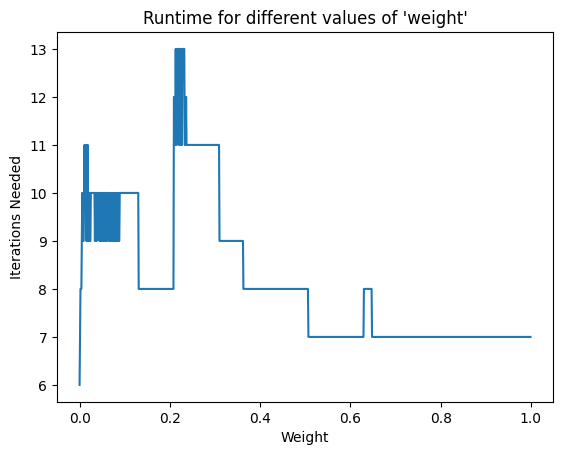

In [10]:
from matplotlib import pyplot as plt 
iterations = m.data['runtime']

iterations = iterations.records.to_numpy()
x = iterations[:,0]
x = [(int(b) - 1)/1000 for b in x] 
y = iterations[:,1]
plt.plot(x, y)
plt.xlabel('Weight')
plt.ylabel('Iterations Needed')
plt.title("Runtime for different values of 'weight'")
plt.show()


# How does having more scenarios impact the runtime?
Here, we test the impact of adding more scenarios, starting with 3 scenarios and going up to 100.

Line 4 and Line 126 need to be changed if you want to run it with more / less scenarios.

In [18]:
gams.reset()
m = gams.exchange_container
# Use python to define scenarios, 100 of them
# Use Python to define yield
# Use gams to define probability in the loop
# Use gams to loop through a subset of scenarios

In [21]:
%%gams
sets
crops /'wheat', 'corn', 'sugarbeets'/
allscenarios /1*1000/
scenarios(allscenarios)
;

table yield(crops,allscenarios) ’possible outcomes for demand’;
yield('wheat', allscenarios) = uniform(1, 6);
yield('corn', allscenarios) = uniform(2, 5);
yield('sugarbeets', allscenarios) = uniform(15, 25);

parameter alpha 'confidence level for CVaR';
alpha = [1/3];


parameter probability(allscenarios) ’probability of each scenario materializing’;

parameter cost(crops) 'cost to plant per acre'
/
wheat 150,
corn 230,
sugarbeets 260
/;

parameter weight;

*----------------------------------------------------------------------- * Form the Benders master problem *-----------------------------------------------------------------------
************************** Sets and Variables Needed to Perform Benders **************************
sets iter ’max Benders iterations’ /iter1*iter2500/,
     dyniter(iter) ’dynamic subset’,
     dynscen(allscenarios) 'dynamic subset of scenarios',
     curiter(iter) 'dynamic subset of iter',
     curscen(allscenarios) 'scenario that the problem should look at'
;

parameters oldgamma(iter),
          oldX(crops, iter),
          oldU(allscenarios, iter),
          pi(allscenarios, crops, iter),
          phi(allscenarios, iter),
          oldY(crops, allscenarios, iter),
          oldP(crops, allscenarios, iter)
          ;
          

************************** Initial Master Problem **************************
positive variables x(crops) '# of acres of land to allocate to wheat, corn, and sugarbeets';

free variables zmaster ’objective variable of master problem’,
               theta ’extra term in master obj’,
               gamma 'VaR'
;

equations masterobj ’master objective function’,
          plantamount 'constraint on first stage variables'
;

masterobj..
    zmaster =e= sum(crops, cost(crops) * x(crops)) + weight * gamma + theta;
    
plantamount..
    sum(crops, x(crops)) =l= 500;

* Set lower bounds for gamma and theta (or else they'd go to -infinity)
gamma.lo = -500000000000;
theta.lo = -500000000000;

model initialmasterproblem /masterobj, plantamount/;

************************** Subproblem **************************
positive variables p(crops, allscenarios) '# of tons of each type of crops to sell in each scenario',
                   y(crops, allscenarios) '# of tons of wheat/corn to buy in each scenario',
                   u(allscenarios) 'auxiliary variables for reformulation of CVaR',
                   subX(crops)
;

free variables zsub,
               subgamma;

equations subobj(allscenarios),
          CVaRConstraint(allscenarios),
          wheatfeeding(allscenarios),
          cornfeeding(allscenarios),
          sellingBeets(allscenarios),
          setx(crops, iter),
          setgamma
;

* Lots of equations here are indexed by scenarios, but there should only be one active scenario at a time.
subobj(curscen)..
    zsub =e= (weight) * ([1/(1-alpha)] * (probability(curscen) * u(curscen))) + (1-weight) * (probability(curscen) * (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)));
    
CVaRConstraint(curscen)..
    u(curscen) =g= (238 * y('wheat', curscen) + 210 * y('corn', curscen) - 170 * p('wheat', curscen) - 150 * p('corn', curscen) - 36 * p('sugarbeets', curscen)) - subgamma;
    
wheatfeeding(curscen)..
    yield('wheat', curscen) * subX('wheat') + y('wheat', curscen) - p('wheat', curscen) =g= 200;

cornfeeding(curscen)..
    yield('corn', curscen) * subX('corn') + y('corn', curscen) - p('corn', curscen) =g= 240;

sellingBeets(curscen)..
    p('sugarbeets', curscen) =l= yield('sugarbeets', curscen) * subX('sugarbeets');

setx(crops, curiter)..
    subX(crops) =e= oldX(crops, curiter);

setgamma(curiter)..
    subgamma =e= oldgamma(curiter);
    
model subproblem /subobj, CVaRConstraint, wheatfeeding, cornfeeding, sellingBeets, setx, setgamma/;

************************** Master Problem **************************
equation cutcon(iter);

cutcon(dyniter)..
    theta =g= sum(scenarios, weight * [1/(1-alpha)] * (probability(scenarios) * oldU(scenarios, dyniter))) +
              sum(scenarios, (1-weight) * probability(scenarios) * (238 * oldY('wheat', scenarios, dyniter) + 210 * oldY('corn', scenarios, dyniter) - 170 * oldP('wheat', scenarios, dyniter) - 150 * oldP('corn', scenarios, dyniter) - 36 * oldP('sugarbeets', scenarios, dyniter))) + 
              sum(crops, sum(scenarios, pi(scenarios, crops, dyniter) * (x(crops) - oldx(crops, dyniter)))) +
              sum(scenarios, phi(scenarios, dyniter) * (gamma - oldgamma(dyniter)));

model masterproblem /masterobj, plantamount, cutcon/;

* Variables needed to run different version of the algorithm
set runs /1 * 1000/;
*set scenSubset(scenarios);
parameter runtime(runs);
scalar lowerbound;
scalar upperbound;
parameter objsub(allscenarios);
scalar objmaster;
scalar counter;
scalar scenSubsetSize;

option limrow = 0;
option limcol = 0;
subproblem.solprint = 0;
masterproblem.solprint = 0;

loop(runs,
    loop(allscenarios,
        if ((ord(allscenarios) = ord(runs)),
        scenarios(allscenarios) = yes;
        );
    );

    weight = 0.5;
    scenSubsetSize = card(scenarios);
    probability(scenarios) = [1/scenSubsetSize];
************************** Benders Algorithm **************************
*
* Step 1: Solve master problem without cuts
*
    display scenarios, scenSubsetSize, probability;
    dyniter(iter) = NO;
    curiter(iter) = NO;
    curscen(scenarios) = NO;
    solve initialmasterproblem minimizing zmaster using lp;
    display zmaster.l;
    
    lowerbound = -INF;
    upperbound = INF;
    objsub(scenarios) = 0;
    objmaster = 0;
    objmaster = zmaster.l - theta.l;
    display objmaster;
    
* Save the x and gamma values
    oldX(crops, 'iter1') = x.l(crops);
    oldgamma('iter1') = gamma.l;
    
    
    oldU(scenarios, 'iter1') = 0;
    pi(scenarios, crops, 'iter1') = 0;
    phi(scenarios, 'iter1') = 0;
    oldY(crops, scenarios, 'iter1') = 0;
    oldP(crops, scenarios, 'iter1') = 0;
    
    counter = 1;
        loop(iter,
        if (ord(iter) <> 1,    
            solve masterproblem minimizing zmaster using lp;
* Save values from master problem
            oldX(crops, iter) = x.l(crops);
            oldgamma(iter) = gamma.l;
            lowerbound = zmaster.l;
            objmaster = zmaster.l-theta.l;
            display lowerbound, x.l, oldY, oldP, pi, phi, gamma.l, theta.l;
* Update curiter
            counter = counter + 1;
        );
        
*
* Step 2: Solve subproblems
*
        dyniter(iter) = yes;
        curiter(iter) = yes;
        loop(scenarios,
            curscen(scenarios) = yes;
            solve subproblem minimizing zsub using lp;
            display x.l;
            display p.l, y.l, gamma.l, theta.l;
* Save values from this subproblem
            oldU(curscen, iter) = u.l(curscen);
            pi(scenarios, crops, iter) = setx.m(crops, iter);
            phi(scenarios, iter) = setgamma.m(iter);
            oldY(crops, scenarios, iter) = y.l(crops, scenarios);
            oldP(crops, scenarios, iter) = p.l(crops, scenarios);
            objsub(scenarios) = zsub.l;
            curscen(scenarios) = no;
        );
        
    upperbound = min(upperbound, objmaster + (weight) * ([1/(1-alpha)] * sum(scenarios, probability(scenarios) * oldU(scenarios, iter))) + (1-weight) * (sum(scenarios, probability(scenarios) * (238 * oldY('wheat', scenarios, iter) + 210 * oldY('corn', scenarios, iter) - 170 * oldP('wheat', scenarios, iter) - 150 * oldP('corn', scenarios, iter) - 36 * oldP('sugarbeets', scenarios, iter)))));
    
*
* Step 3: Check for convergence
*
        display lowerbound,upperbound, counter, oldU, oldY, oldP;
        if (abs(upperbound - lowerbound < 10),
            runtime(runs) = counter;
            break;
        );
        curiter(iter) = no;
    );
);
display runtime;


GamsExceptionExecution: GAMS return code not 0 (3), check /Users/hongkai/Desktop/Optimization/jup/gj_5ffed512_base_3.lst for more details

In [20]:
from matplotlib import pyplot as plt 
iterations = m.data['runtime']
iterations = iterations.records.to_numpy()
x = iterations[:,0]
x = [int(b) for b in x] 
y = iterations[:,1]
plt.plot(x, y)
plt.xlabel('Number of Scenarios')
plt.ylabel('Iterations Needed')
plt.title("Runtime for different number of scenarios")
plt.show()


KeyError: 'runtime'